# Transformer Implementation 
## Attention is All You Need
### The Annotated Transformer
References
- Harvard NLP 'The Annotated Transformer': http://nlp.seas.harvard.edu/2018/04/03/attention.html 
- post: https://cpm0722.github.io/pytorch-implementation/transformer 
- post: https://paul-hyun.github.io/transformer-01/ 

# 0.Prelims

In [22]:
import pandas as pd 
import numpy as np 
import math, copy, time  
import matplotlib.pyplot as plt 
import seaborn 
seaborn.set_context(context='talk')
%matplotlib inline 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable 

from IPython.display import Image
from PIL import Image   

# 1.Model Architecture
- Transformer
    - stacked self-attention
    - point-wise, fully connected layers 
    - encoder and decoder 
1. encoder-decoder structure: 
    - most competitive neural sequence transduction models have an encoder-decoder structure
        - encoder: maps an input sequence of symbol representations $(x_1, .., x_n)$ to a sequence of continuous representations $z=(z_1,...,z_n)$ 
        - decoder: given z, generates an output sequence $(y_1,...,y_n)$ of symbols one eleement at a time. 
2. auto-regressive: 
    - consuming the previously generated symbols as additional input when generating the next

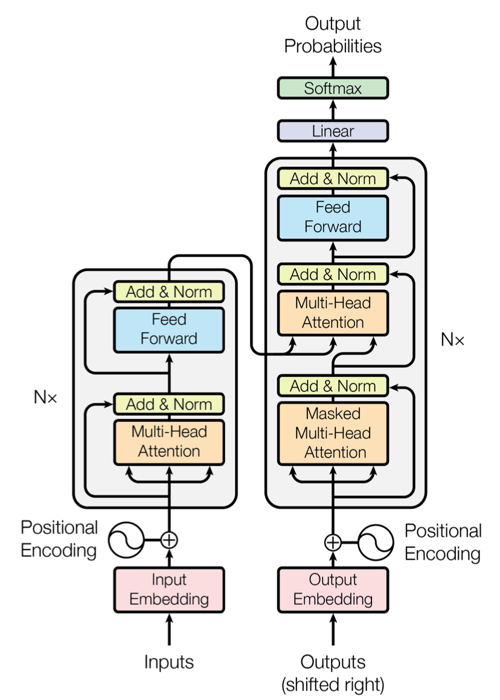

In [23]:
# overall architecture for Transformer's Encoder & Decoder: satacked self-attention & point-wise fully connected layers 
Image.open("C:\\Users\\user\\OneDrive\\사진\\transformer_structure_in_paper.png").resize((500,700))

In [24]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder 
        self.src_embed = src_embed 
        self.tgt_embded = tgt_embed 
        self.generator = generator 
        
    # Feed-Forward Neural Network: take in and process masked src and target sequences
    def forward(self, src, tgt, src_mask, tgt_mask): 
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)  # auto-regressive: encoder's output = decoder's input   
    
    # Encoder
    def encode(self, src, src_mask): 
        return self.encoder(self.src_embed(src), src_mask)
    
    # Decoder 
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self. decoder(self.tgt_embded(tgt), memory, src_mask, tgt_mask)

In [25]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__() 
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) # log_softmax: log(softmax) --> more stable and faster than computing log after softmax 

## 1.1 Encoder and Decoder Stacks

### 1.1.1 Encoder
- The encoder is composed of a stack of $N=6$ identical layers (6 Encoder Blocks)
- Each encoder blocks include higher dimensional `context` about input vector
    - high dimension = more abstract

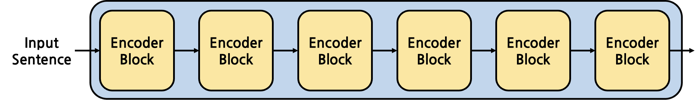

In [26]:
Image.open("C:\\Users\\user\\OneDrive\\사진\\encoder6.png").resize((700,100))

In [27]:
# the encoder is composed of a stack of N=6 identical layers  
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])  # copy.deepcopy: copy of model to save the best model 
                                                                     # if no save model --> best_model_state always update --> overfitting 

In [28]:
class Encoder(nn.Module):
    # core encoder is a stack of N layers 
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)  # defined LayerNorm class right below 
        
    def forward(self, x, mask):
        # pass the input (and mask) through each layer in turn
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)       

- the output of each sub-layer is $LayerNorm(x + Sublayer(x))$
- $Sublayer(x)$: funciton implemented by the sub-layer itself 

In [29]:
# employ a residual connection around each of the 2 sub-layers 
# followed by Layer Normalization 
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps 
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean) / (std+self.eps) + self.b_2   

- $d_{\text{model}} = 512$
    - To facilitate these residual connections
    - all sub-layers in the model, as well as the embedding layers
    - produce outputs of dimension 512 

In [30]:
class SublayerConnection(nn.Module):
    # residual connection followed by a layer norm
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        # apply residual connection to any sublyer with the same size
        return x + self.dropout(sublayer(self.norm(x)))   # dropout to the otuput of each sub-layer
                                                          # before it's added to the sub-layer input x and normalized   

In [31]:
class EncoderLayer(nn.Module): 
    # encoder is made up of self-attention and feed forward
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward 
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size 

### 1.1.2 Decoder
The decoder is also composed of a stack of $N = 6$ identical layers.

In [32]:
class Decoder(nn.Module):
    # Generic N layer decoder with masking 
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)    

- Multi-head attention
    - in addition to the sub-layers in each encoder layer, the decoder inserts a 3rd sub-layer 
    - which performs multi-head attention over the output of the encoder stack 
- residual connections around each of the sub-layers, followed by layer normalization

In [33]:
class DecoderLayer(nn.Module):
    # decoder is made of self-attn, src-attn, and feed forward 
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size 
        self.self_attn = self_attn 
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory 
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))        
        return self.sublayer[2](x, self.feed_forward)


- Masking:
    - modify the self-atteention sub-layer in the deocder stack to prevent positions from attending to subsequent positions
    - combined with fact that the output embeddings are offset by one position, ensure that the predictions for position $i$ can depend only on the unknown outputs at positions less than $i$
    - position each tgt word(row) is allowed to look at (column) 
    - words are blocked for attending to future words during training

In [34]:
def subsequent_mask(size):
    # mask out subsequent positions
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('unit8')  # ?????
    return torch.from_numpy(subsequent_mask) == 0 

In [35]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

TypeError: data type 'unit8' not understood

<Figure size 500x500 with 0 Axes>

## 1.2 Attention
- $Q, K, V$
    - attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors 
    - $\text{output} = \text{weighted sum of the value}$
        - weight assigne to each value is computed by a compatibility function fo the query with the corresponding key 
- Scaled Dot-Product Attnetion
    - the input consists of 
        - queries and keys of dimension $d_k$
        - and values of dimension $d_v$  
        - compute the dot products of the query with all keys, divide each by $\sqrt(d_k)$, and apply a softmax function to obtain the weights on the values 
    - Attention function: 
    $$ Attention(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V = \frac{\exp(\frac{QK^T}{\sqrt{d_k}})}{\sum_{j=1}^{n}\exp(\frac{QV_j^T}{\sqrt{d_k}})}V $$
- Attention functions
    1. additive attetnion 
        - computes the compatibility using Feed-Forward Network with a SINGLE hiddle layer 
    2. **dot-product (multiplicative) attention [This Algorithm!]**
        - much faster, more space-efficient in practice 
            - since it can be implemented using highly optimized matrix multiplication code    
        - for small values of $d_k$: the two mechanisms perform similarly
        - for large values of $d_k$: dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients
            - to counteract this effect, we scale the dot products by $ \frac{1}{\sqrt{d_k}} $

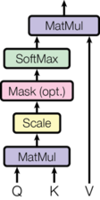

In [ ]:
Image.open("C:\\Users\\user\\OneDrive\\사진\\attention_funciton.png").resize((100,200))

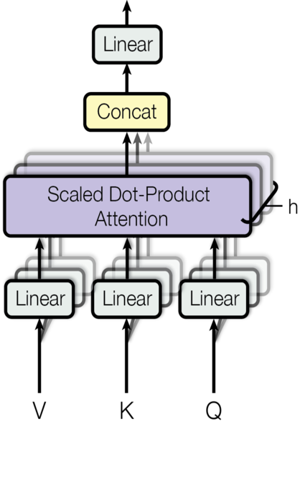

In [37]:
Image.open("C:\\Users\\user\\OneDrive\\사진\\scaledDotProductAttention.png").resize((300,500))

In [38]:
def attention(query, key, value, mask=None, dropout=None):
    # compute 'Scaled dot Product Attention' 
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)    # ???????? 
    if mask is not None: 
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn       

- Multi-head attention:
    - allows the model to jointly attend to information from different representation subspaces at different positions 
    $$ MultiHead(Q,K,V) = Concat(head_1, ...,head_h)W^o $$  
    $$ where head_i = Attention(QW_i^Q, KW_i^K, VW_i^V) $$
    where the projections are parameter matrices $$  W_i^Q ∈ \mathbb{R}^{d_\text{model}\times d_k} $$
    $$  W_i^K ∈ \mathbb{R}^{d_\text{model}\times d_k} $$
    $$  W_i^V ∈ \mathbb{R}^{d_\text{model}\times d_v} $$
    $$  W^O ∈ \mathbb{R}^{hd_v \times d_\text{model}} $$  
    - reduced dimensions of each head --> the total computational cost is similar to that of single-head attention with full dimensionality 


In [31]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        # take in model size and number of heads 
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # assume d_v == d_k for always 
        self.d_k = d_model // h   # ??????
        self.h = h 
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None 
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # some mask applied to all h heads 
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projection sin bathch from d_model => h x d_k         
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2) for l, x in zip(self.linears, (query, key, value))]
            
        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, drop=self.dropout)
        
        # 3) 'Concat' using a view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        return self.linears[-1](x)  

## 1.3 Position-wise Feed-Forward Networks
- each of the layers in encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically 
- two linear transformations with a ReLU activation in between
$$ FFN(x) = max(0,xW_1+b_1)W_2+b_2 $$
- while the linear transformations are the same across **different positions, they use different parameters from layer to layer** 
- two convolutions with kernel size 1, $d_\text{model}=512$, and the inner-layer has dimensionality $d_{ff}=2048$ 

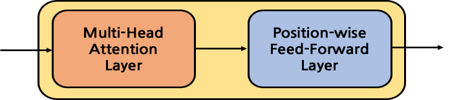

In [10]:
Image.open("C:\\Users\\user\\OneDrive\\사진\\encoder_block.png").resize((450,100))

In [33]:
class PositionwiseFeedForward(nn.Module):
    # implements FFN equation
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x): 
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 1.4 Embeddings and Softmax
- use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_\text{model}$. 
- also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities 
- share the same weight matrix between the two embedding layers and the pre-softmax linear transformation
- in the embedding layers, multiply weights by $\sqrt(d_\text{model})$

In [35]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model 
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 1.5 Positional Encoding
- Attention model contains NO recurrence and NO convolution
    - in order for the model to make use of order of the seuqnece 
    - must inject some information about the relative or absolute position of the tokens in the SEQUENCE 
    - Therefore, add $positional \ encodings$ to the input embeddings at the bottoms of the encoder and decoder stacks 
        - positional encodings have the same dimension $d_{model}$ as the embeddings <-- so that the two can be summed 

In [36]:
class PositionalEncoding(nn.Module): 
    # implement the PE function 
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # compute the positional encodings once in log space 
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x): 
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        
        return self.dropout(x)

In [38]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

AttributeError: module 'torch' has no attribute 'arance'

<Figure size 1500x500 with 0 Axes>

## 1.6 Full Model

In [39]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    # consturct a model from hyperparameters 
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # Initialize parameters with Glorot / fan_avg 
    for p in model.parameters():
        if p.dim() > 1: 
            nn.init.xavier_uniform(p)
    return model 

In [40]:
# small example model
tmp_model  = make_model(10,10,2)

AttributeError: module 'torch' has no attribute 'arance'

# 2.Training

## 2.1 Batches and Masking 
- step 1. define a batch obejct that holds the src and target sentences for training, as well as constructing the masks 

In [47]:
class Batch:
    # object for holding a batch of data with mask during training 
    def __init__(self, src, trg=None, pad=0):
        self.src = src 
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        # create a mask to hide padding and future words 
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## 2.2 Training Loop
- step 2. create a generic training and scoring funciton to keep track of loss 
    - pass in a generic loss compute function that also handles parameter updates 

In [49]:
def run_epoch(data_iter, model, loss_compute):
    # Standard Trianing and logging Function 
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch, trg_y, batch.ntokens)
        total_loss += loss 
        total_tokens += batch.ntokens 
        tokens += batch.ntokens 
        tokens += batch.ntokens 
        if i % 50 == 1: 
            elapsed = time.time() - start 
            print('Epoch Step: %d Loss: %f Tokens per SEc: %f' %(i, loss / batch.ntokens, tokens / elapsed)) 
            start = time.time()
            tokens = 0
        return total_loss / total_tokens

## 2.3 Training Data and Batching 
We trained on the standard WMT 2014 English-German dataset consisting of about 4.5 million sentence pairs. Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens. For English- French, we used the significantly larger WMT 2014 English-French dataset consisting of 36M sentences and split tokens into a 32000 word-piece vocabulary.

Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.

In [51]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    # keep augmenting batch and calculate total number of tokens + padding 
    global max_src_in_batch, max_tgt_in_batch
    if count == 1: 
        max_src_in_batch = 0
        max_tgt_in_batch = 0
        
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch 
    
    return max(src_elements, tgt_elements)

## 2.4 Hardware and Schedule 

## 2.5 Optimizer ★★★★
- Adam optimizer 
- varied the learning rate over the course of training, according to the formula 
    - increasing the learning rate linearly for the first $warmup \ steps$ trianing steps, and
    - decreasing it thereafter proportionally to the inverse square root of the step number 
    - $warmup \ steps = 4000$

In [57]:
class Noamopt: 
    # Optim wrapper that implements rate 
    def __init__(self, model_size, factor, warmup, optimizer): 
        self.optimizer = optimizer 
        self._step = 0
        self.warmup = warmup
        self.factor = factor 
        self.model_size = model_size 
        self._rate = 0 
        
    def step(self): 
        # update parameters and rate 
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups: 
            p['lr'] = rate 
        self._rate = rate 
        self.optimizer.step()
        
    def rate(self, step = None):
        # implement 'lrate' above 
        if step is None: 
            step = self._step 
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step*self.warmup**(-1.5)))
    
    def get_std_opt(model):
        return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [58]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]

plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legnd(['512:4000', '512:8000', '256:4000'])

NameError: name 'NoamOpt' is not defined

# 3.Regularization

## 3.1 Label Smoothing
$$\epsilon_{ls}=0.1$$
this hurts perplexity, as the model elarns to be more unsure, but improves accuracy and BLEU score

In [59]:
class LabelSmoothing(nn.Module): 
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx 
        self.confidence = 1.0 - smoothing 
        self.size = size 
        self.true_dist = None 
    
    def forward(self, x, target):
        assert x.size(1) == self.size 
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size-2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist 
        return self.criterion(x, Variable(true_dist, requires_grad=False))
        

In [60]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.float([[0, 0.2, 0.7, 0.1, 0],
                       [0, 0.2, 0.7, 0.1, 0],
                       [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2,1,0])))

plt.imshow(crit.true_dist)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


TypeError: 'torch.dtype' object is not callable

In [63]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x): 
    d = x+3*1 
    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d],
                                 ])
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).data[0]
    
plt.plot(np.arange(1,100), [loss(x) for x in range(1,100)])

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


AttributeError: 'LabelSmoothing' object has no attribute 'smoothing'